### Project Name: House Prices
Scope: The goal is to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 


### Content
1. Gathering Data
2. EDA
3. Feature Engineering
4. Feature Selection
5. Model Building
6. Model Deployment

In [2]:
try:
    from IPython import get_ipython
    get_ipython().magic('clear')
    get_ipython().magic('reset -f')
except:
    pass

# 1. Import Libraries

In [119]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from fast_ml.feature_selection import get_duplicate_features
pd.pandas.set_option('display.max_columns', None)
import os
import pathlib
from geopy.geocoders import Nominatim
import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import itertools
from scipy.stats import chi2_contingency
from itertools import product
import scipy.stats as ss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import pickle


import warnings
warnings.filterwarnings("ignore")

# 2. Functions

In [4]:
## GENERAL FUNCTIONS
# 1.1 Function for features to delete
def to_delete(df, name):
    path = r'/Users/macbookpro/Desktop/PYTHON/1. PROJECTS/1. House Prices/2. Delete/'
    # name = input('Name of the file: ')
    if type(df) == list:
        df1 = pd.DataFrame(df, columns = ['Columns'])
        df1.to_csv(path + "/" + name, header=None, index=None, sep=",", mode="w")
    else:
        df.to_csv(path + "/" + name, header=None, index=None, sep=",", mode="w")


# 1.2 Function for features to keep
def to_keep(df, name):
    path = r'/Users/macbookpro/Desktop/PYTHON/1. PROJECTS/1. House Prices/1. Keep/'
    # name = input('Name of the file: ')
    if type(df) == list:
        df1 = pd.DataFrame(df, columns = ['Columns'])
        df1.to_csv(path + "/" + name, header=None, index=None, sep=",", mode="w")
    else:
        df.to_csv(path + "/" + name, header=None, index=None, sep=",", mode="w")


# 1.3 Function for indetify if two columns have the same values
def duplicate_features(df, var1, var2):
    df_dupl = df[[var1, var2]].apply(pd.Series.value_counts)
    df_dupl['Equal'] = np.where(df_dupl[var1] == df_dupl[var2], 1,0)
    print('Columns have the same values: ', df_dupl['Equal'].sum() == df_dupl.shape[0])
    return df_dupl.head(2)


# 1.4 compute the vif for all given features
def compute_vif(considered_features):
    
    X = train[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif


# 1.5 Calculate outliers with IQR method for the whole dataframe
def calc_outliers_df(df):
    # Calculate the 1st and the 3rd quartile
    q1 = df.quantile(.25)
    q3 = df.quantile(.75)

    # Calculate interquartile range
    iqr = q3 - q1

    # Eliminate outliers from the dataset
    df1 = df[~((df < (q1 - 1.5 * iqr)) |(df > (q3 + 1.5 * iqr))).any(axis=1)]

    return df1


# 1.6 Calculate outliers with IQR method for specific feature
def calc_outliers_var(df, x):
    # Calculate the 1st and the 3rd quartile
    q1 = df[x].quantile(.25)
    q3 = df[x].quantile(.75)

    # Calculate interquartile range
    iqr = q3 - q1

    # Eliminate outliers from the dataset
    high_fence = q1 - 1.5 * iqr
    low_fence = q3 + 1.5 * iqr

    return high_fence, low_fence

# 1.7 Calculate the distribution of a value
def distribution(df, x):
    return df[x].value_counts(normalize=True).round(2).mul(100)



### GRAPHS ###
# 2.1 Boxplot
def box_plot(df, x):
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(15,5))
    plt.title('Boxplot');
    sns.boxplot(df[x]);


# 2.2 Distplot
def distplot(df, x):  
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(15,5))
    sns.distplot(df[x])

    print('Skewness of the {} is : {}'.format(x, df[x].skew()))

    plt.axvline(x = df[x].mean(), linewidth = 3, color='g', label = 'mean', alpha=.5)
    plt.axvline(x = df[x].median(), linewidth = 3, color='r', label = 'median', alpha=.5)

    plt.legend()
    plt.show()

# 2.3 Histplot
def histplot(df, x):
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(15,5))
    plt.title('Histplot');
    sns.histplot(df[x]);

# 3. Gathering Data

In [5]:
# Import training dataset
df1 = pd.read_csv(r'/Users/macbookpro/Desktop/PYTHON/1. PROJECTS/1. House Prices/house-prices-advanced-regression-techniques/train.csv')

In [8]:
# Copy datasets
train = df1.copy()

## 3.1 Inspect data

In [9]:
print('Shape of the dataset: ', train.shape)
train.head()

Shape of the dataset:  (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 5. FEATURE ENGINEERING
## 5.1 Study Targeted Variable
### 5.1.1 Missing values

In [36]:
# Copy
train_1 = train.copy()

In [37]:
# Check for null values
print('Number of null values: ', train_1['SalePrice'].isna().sum())

Number of null values:  0


### 5.1.2 Outliers
- We already know that there are outliers in our dataset and it makes our dataset skewed
- The percentage of outliers to the whole dataset is 4.2%
- We will not remove outliers even if number of outliers is only 4.2%, but we will impute them by replace extreme values with the high fence 
- By imputing outliers and check them, it seems that there are not any outliers in the targeted variable

In [38]:
print('Lower fence: ', calc_outliers_var(train_1, 'SalePrice')[0])
print('Higher fence: ', calc_outliers_var(train_1, 'SalePrice')[1])

low_fence = calc_outliers_var(train_1, 'SalePrice')[0]
high_fence = calc_outliers_var(train_1, 'SalePrice')[1]

Lower fence:  3937.5
Higher fence:  340037.5


In [39]:
print('Number of cases that are less than low fence are: ', train_1.loc[train_1['SalePrice']<low_fence].shape[0])
print('Number of cases that are more than high fence are: ', train_1.loc[train_1['SalePrice']>high_fence].shape[0])
print('The percentage of outliers to the whole dataset is: ', round((train_1.loc[train_1['SalePrice']>high_fence].shape[0]/train_1.shape[0])*100,1))

Number of cases that are less than low fence are:  0
Number of cases that are more than high fence are:  61
The percentage of outliers to the whole dataset is:  4.2


In [40]:
# Impute extreme values with high fence
train_1.loc[train_1['SalePrice']>=high_fence, 'SalePrice'] = high_fence

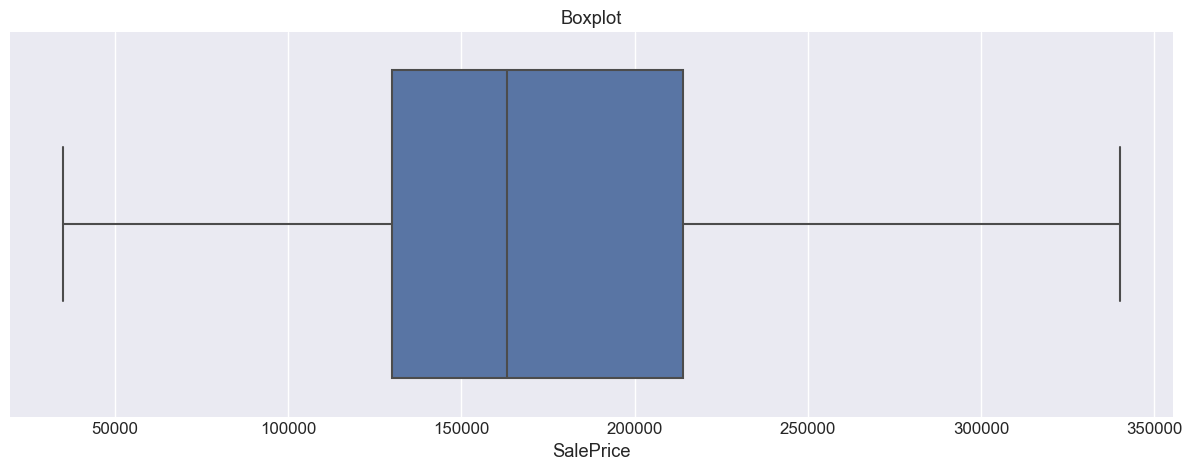

In [41]:
# Check for outliers
box_plot(train_1, 'SalePrice')

### 5.1.3 Skewness
- Even if the outliers are imputed in the previous step and there are not exist any other outliers in the targeted variable, skewness still exist (positive skewness)
- After transforming the targeted variable, the shape of the plot is more symetrical and skewness is very close to zero

Skewness of the SalePrice is : 0.8027863231337099


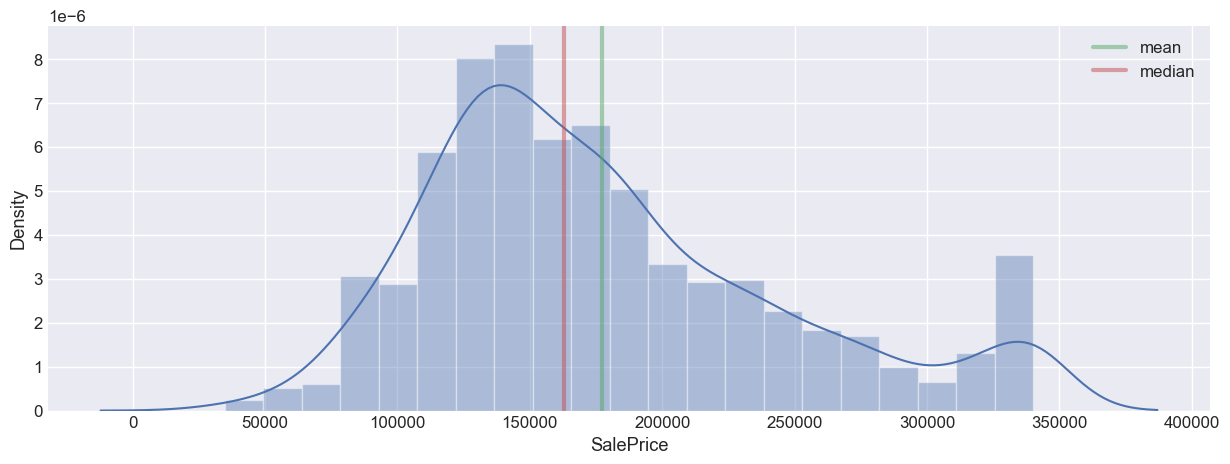

In [42]:
# Check skewness of the targeted variable
distplot(train_1,'SalePrice')

Skewness of the SalePrice is : -0.18514961386141116


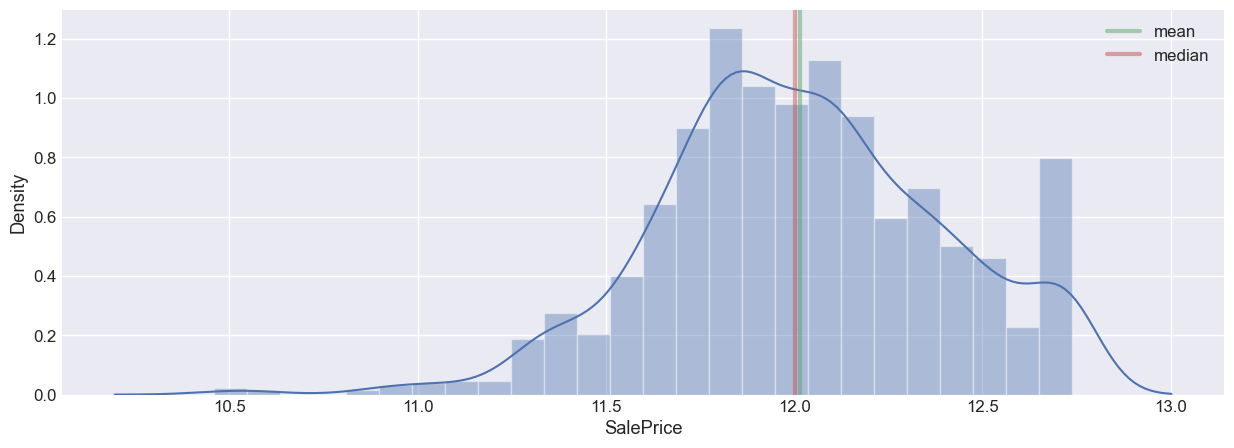

In [43]:
# We use logarithmic transformation to eliminate the skewness of the variable
train_1['SalePrice'] = np.log(train_1['SalePrice'])

# Check the skewness by plotting it
distplot(train_1, 'SalePrice')

## 5.2 Numeric Features

In [44]:
num_var = train_1[['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'SalePrice']]

print('Shape of the subset of numeric features: ', num_var.shape)
num_var.head(2)

Shape of the subset of numeric features:  (1460, 33)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
0,1,60,65.0,8450,7,5,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,12.247694
1,2,20,80.0,9600,6,8,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,12.109011


### 5.2.1 Missing values
- As we have analysed in the EDA section in more detail we will use median value to impute the missing values

In [45]:
# Percentage of missing values
prc_missing_num = num_var.isna().sum()*100/len(num_var)
missing_num = pd.DataFrame(prc_missing_num, columns=['Missing values'])
missing_num.index.name = 'Features'
missing_num = missing_num.reset_index()     

# Check Features with missing values and prc of missing values 
missing_num.loc[missing_num['Missing values']>0]

,Features,Missing values
2,LotFrontage,17.739726
6,MasVnrArea,0.547945


In [46]:
# Impute missing values by using median
train_1['LotFrontage'] = train_1['LotFrontage'].fillna(train_1['LotFrontage'].median())
train_1['MasVnrArea'] = train_1['MasVnrArea'].fillna(train_1['MasVnrArea'].median())

In [47]:
# Check if there is missing values somewhere in the dataset
print('There are missing values in the dataset: ', num_var.isna().sum().any())

There are missing values in the dataset:  True


### 5.2.2 Cardinality
* Features cardinality is not as high as we can safely drop these columns
* There are not features with low cardinality (number of unique values = 1)

In [48]:
# High or Low Feature Variability
col_1 = []

for col in num_var.columns:
    col_1.append([col, num_var[col].nunique(), len(num_var), round((num_var[col].nunique()/len(num_var))*100, 3)])

# Dataframe with statistics of columns
col_1_df = pd.DataFrame(col_1, columns=['Columns','Unique Values','Dataset Length','Percentage'])

print('Shape of the dataset: ', col_1_df.shape, '\n')
col_1_df.head()

Shape of the dataset:  (33, 4) 



,Columns,Unique Values,Dataset Length,Percentage
0,Id,1460,1460,100.000
1,MSSubClass,15,1460,1.027
2,LotFrontage,110,1460,7.534
3,LotArea,1073,1460,73.493
4,OverallQual,10,1460,0.685


In [49]:
# Check the number of features which percentage is greater than the mean
col_1_df.loc[col_1_df['Percentage']> col_1_df['Percentage'].mean()].sort_values('Percentage', ascending=True)

,Columns,Unique Values,Dataset Length,Percentage
6,MasVnrArea,327,1460,22.397
12,2ndFlrSF,417,1460,28.562
24,GarageArea,441,1460,30.205
32,SalePrice,606,1460,41.507
7,BsmtFinSF1,637,1460,43.630
10,TotalBsmtSF,721,1460,49.384
11,1stFlrSF,753,1460,51.575
9,BsmtUnfSF,780,1460,53.425
14,GrLivArea,861,1460,58.973
3,LotArea,1073,1460,73.493


In [50]:
# Check the features with low cardinality
col_1_df.loc[col_1_df['Unique Values'] == 1]

,Columns,Unique Values,Dataset Length,Percentage


### 5.2.3 Distribution of unique values
Indetify features that suck up all the variance. When 95%+ of observations fall under one value, we can safely drop as they do not provide enough variability to be meaningful.

In [51]:
# Distribution
col_2 = []
for col in num_var.columns:
    counts = num_var[col].value_counts(dropna=False, normalize=True)
    valids = counts[counts>.95].index
    if valids.notna():
        col_2.append(col)

print('Number of features is: ', len(col_2))
print('Features:')
display(col_2)

Number of features is:  5
Features:


['LowQualFinSF', 'KitchenAbvGr', '3SsnPorch', 'PoolArea', 'MiscVal']

In [52]:
# Drop unecessary features from the grand dataset
train_2 = train_1.drop(col_2, axis = 1)
print('Shape of the dataset before removing highly distributed variables is: ',train_1.shape)
print('Shape of the dataset after removing highly distributed variables is:: ', train_2.shape)

Shape of the dataset before removing highly distributed variables is:  (1460, 81)
Shape of the dataset after removing highly distributed variables is::  (1460, 76)


In [53]:
# Drop unecessary features from the subset with numeric features 
num_var_1 = num_var.drop(col_2, axis = 1)
print('Shape of the dataset before removing highly distributed variables is: ',num_var.shape)
print('Shape of the dataset after removing highly distributed variables is:: ', num_var_1.shape)

Shape of the dataset before removing highly distributed variables is:  (1460, 33)
Shape of the dataset after removing highly distributed variables is::  (1460, 28)


In [54]:
# Export drop due to distribution
name = 'Gathering_Data_Distribution.txt'
to_delete(col_2, name)

### 5.2.4 Duplicate Features
There are not duplicated features.

In [55]:
# function to detect duplicate features 
duplicate_features_1 = get_duplicate_features(num_var_1)
duplicate_features_1

,Desc,feature1,feature2


### 5.2.5 Outliers
* We keep only outliers the numeric features that are highly correlated with the targeted variable (19 vs 16)
* Due to the fact that the size of dataset is not very large, we impute outliers by replacing them with high fence variable

In [56]:
# High correlated variables with targeted variable
list1 = corr_trg[corr_trg>.3].sort_values(ascending=False).index.to_list()

# Numeric variables
list2 = num_var_1.columns.to_list()

# Sprecify the numeric variables that are highly correlated with target variable
inner_list = list(set(list1).intersection(list2))

# Remove target variable from the list
inner_list.remove('SalePrice')

print('Number of highly cerrelated variables: ', len(list1))
print('Number of highly correlated numeric variables: ', len(inner_list))

Number of highly cerrelated variables:  19
Number of highly correlated numeric variables:  15


In [57]:
# Create an empty dataframe as well as empty lists
frame = pd.DataFrame(columns=['Column','High Fence'])
high_ls = []
sthles = []

# Calculate high fence value per variable 
for col in inner_list:
    high = calc_outliers_var(num_var_1, col)[1]  
    sthles.append(col)
    high_ls.append(high)

# Add them to the dataframe 
frame['Column'] = sthles
frame['High Fence'] = high_ls

frame

,Column,High Fence
0,1stFlrSF,2155.125
1,OverallQual,10.000
2,OpenPorchSF,170.000
3,TotRmsAbvGrd,10.000
4,2ndFlrSF,1820.000
5,BsmtFinSF1,1780.625
6,TotalBsmtSF,2052.000
7,GarageArea,938.250
8,FullBath,3.500
9,MasVnrArea,415.000


In [58]:
# Transpose the dataframe 
frame_T = frame.set_index('Column').transpose()
frame_T

Column,1stFlrSF,OverallQual,OpenPorchSF,TotRmsAbvGrd,2ndFlrSF,BsmtFinSF1,TotalBsmtSF,GarageArea,FullBath,MasVnrArea,Fireplaces,GrLivArea,GarageCars,LotFrontage,WoodDeckSF
High Fence,2155.125,10.0,170.0,10.0,1820.0,1780.625,2052.0,938.25,3.5,415.0,2.5,2747.625,3.5,111.5,420.0


In [59]:
# Replace outliers with high fence value 
for col in frame_T.columns.intersection(train_2.columns):
    train_2.loc[train_2[col] > frame_T.iloc[0][col], col] = frame_T.iloc[0][col]

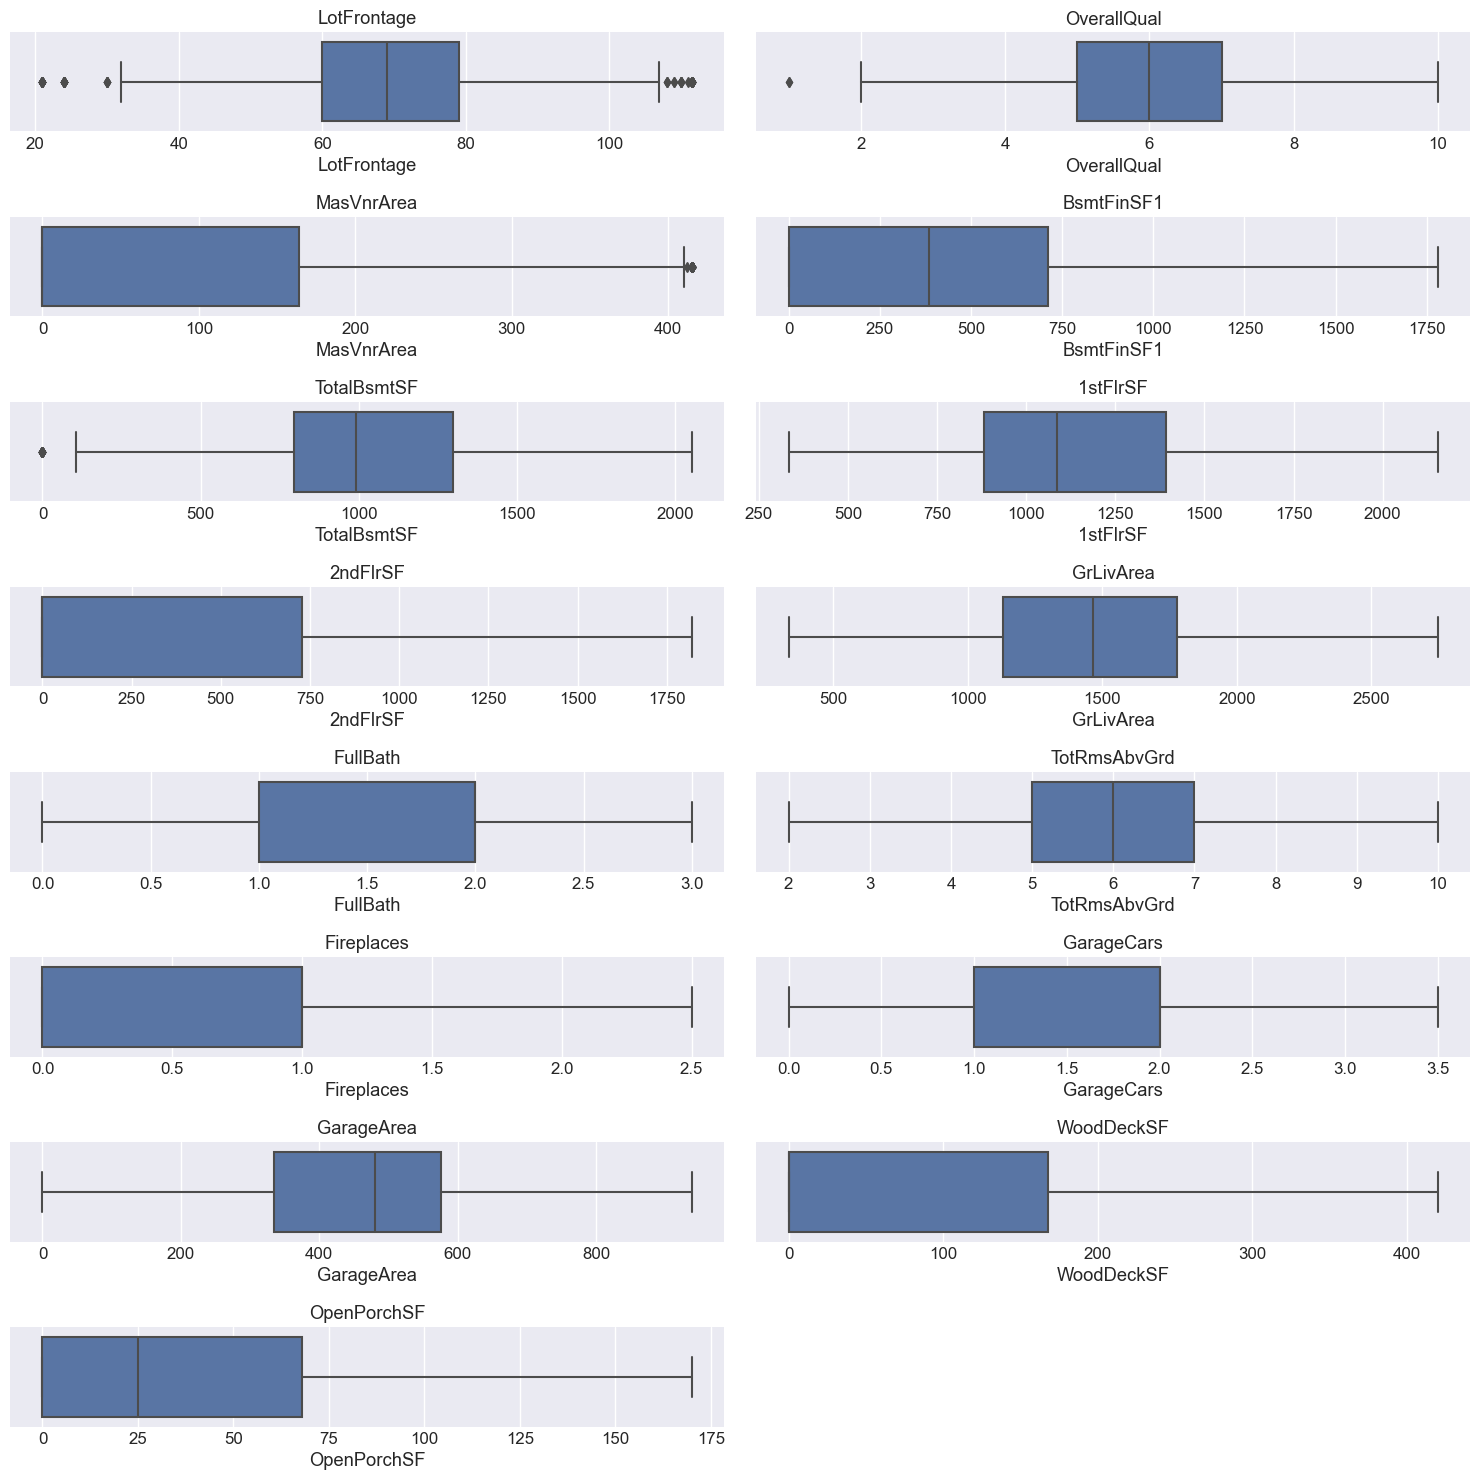

In [60]:
# Check - Plot boxplots for imputed variables  
x, y, z = 8, 2, 1

plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(15,15))

# Check imputed variables by visualize them 
for col in train_2.columns:
    if col in sthles:
        plt.subplot(x,y,z);
        plt.title('{}'.format(col));
        sns.boxplot(train_2[col]);
        z = z + 1

plt.tight_layout()
plt.show()

## 5.3 Categorical Features

In [61]:
# Copy
train_3 = train_2.copy()
print('Shape of the dataset: ', train_3.shape)
train_3.head(1)

Shape of the dataset:  (1460, 76)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0,150,856,GasA,Ex,Y,SBrkr,856.0,854,1710.0,1,0,2.0,1,3,Gd,8,Typ,0.0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,NaN,NaN,NaN,2,2008,WD,Normal,12.247694


In [62]:
# Specify the categorical features 
cat_var = train_3.select_dtypes(include='object')
cat_var.head(2)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


### 5.3.1 Missing values
* There many variables with null values
* Impute the majority of them by using the documentation

In [63]:
# Percentage of missing values
prc_missing_cat = cat_var.isna().sum()*100/len(cat_var)
missing_cat = pd.DataFrame(prc_missing_cat, columns=['Missing values'])
missing_cat.index.name = 'Features'
missing_cat = missing_cat.reset_index()  
missing_cat = missing_cat.sort_values('Missing values', ascending=False)   

# Check Features with missing values and prc of missing values 
missing_cat.loc[missing_cat['Missing values']>0]

,Features,Missing values
38,PoolQC,99.520548
40,MiscFeature,96.301370
2,Alley,93.767123
39,Fence,80.753425
32,FireplaceQu,47.260274
33,GarageType,5.547945
36,GarageCond,5.547945
35,GarageQual,5.547945
34,GarageFinish,5.547945
25,BsmtFinType2,2.602740


In [64]:
# Impute null values for categorical features - grand dataset
train_3['PoolQC'] = train_3['PoolQC'].fillna('No Pool')
train_3['MiscFeature'] = train_3['MiscFeature'].fillna('None')
train_3['Alley'] = train_3['Alley'].fillna('No alley access')
train_3['Fence'] = train_3['Fence'].fillna('No Fence')
train_3['FireplaceQu'] = train_3['FireplaceQu'].fillna('No Fireplace')
train_3['GarageType'] = train_3['GarageType'].fillna('No Garage')
train_3['GarageCond'] = train_3['GarageCond'].fillna('No Garage')
train_3['GarageQual'] = train_3['GarageQual'].fillna('No Garage')
train_3['GarageFinish'] = train_3['GarageFinish'].fillna('No Garage')
train_3['BsmtFinType2'] = train_3['BsmtFinType2'].fillna('No Basement')
train_3['BsmtExposure'] = train_3['BsmtExposure'].fillna('No Basement')
train_3['BsmtFinType1'] = train_3['BsmtFinType1'].fillna('No Basement')
train_3['BsmtQual'] = train_3['BsmtQual'].fillna('No Basement')
train_3['BsmtCond'] = train_3['BsmtCond'].fillna('No Basement')
train_3['MasVnrType'] = train_3['MasVnrType'].fillna('None')
train_3['Electrical'] = train_3['Electrical'].fillna(train_3['Electrical'].value_counts().sort_values(ascending=False).index[0])

In [65]:
# Impute null values for categorical features - subset
cat_var['PoolQC'] = cat_var['PoolQC'].fillna('No Pool')
cat_var['MiscFeature'] = cat_var['MiscFeature'].fillna('None')
cat_var['Alley'] = cat_var['Alley'].fillna('No alley access')
cat_var['Fence'] = cat_var['Fence'].fillna('No Fence')
cat_var['FireplaceQu'] = cat_var['FireplaceQu'].fillna('No Fireplace')
cat_var['GarageType'] = cat_var['GarageType'].fillna('No Garage')
cat_var['GarageCond'] = cat_var['GarageCond'].fillna('No Garage')
cat_var['GarageQual'] = cat_var['GarageQual'].fillna('No Garage')
cat_var['GarageFinish'] = cat_var['GarageFinish'].fillna('No Garage')
cat_var['BsmtFinType2'] = cat_var['BsmtFinType2'].fillna('No Basement')
cat_var['BsmtExposure'] = cat_var['BsmtExposure'].fillna('No Basement')
cat_var['BsmtFinType1'] = cat_var['BsmtFinType1'].fillna('No Basement')
cat_var['BsmtQual'] = cat_var['BsmtQual'].fillna('No Basement')
cat_var['BsmtCond'] = cat_var['BsmtCond'].fillna('No Basement')
cat_var['MasVnrType'] = cat_var['MasVnrType'].fillna('None')
cat_var['Electrical'] = cat_var['Electrical'].fillna(cat_var['Electrical'].value_counts().sort_values(ascending=False).index[0])

In [66]:
# Check if there is missing values somewhere in the dataset
print('There are missing values in the dataset: ', cat_var.isna().sum().any())

There are missing values in the dataset:  False


### 5.3.2 Cardinality
* There are not variables with only one unique value 
* There are not variables with very high cardinality

In [67]:
# High or Low Feature Variability
col_3 = []

for col in cat_var.columns:
    col_3.append([col, cat_var[col].nunique(), len(cat_var), round((cat_var[col].nunique()/len(cat_var))*100, 3)])

# Dataframe with statistics of columns
col_3_df = pd.DataFrame(col_3, columns=['Columns','Unique Values','Dataset Length','Percentage'])

print('Shape of the dataset: ', col_3_df.shape, '\n')
col_3_df.head()

Shape of the dataset:  (43, 4) 



,Columns,Unique Values,Dataset Length,Percentage
0,MSZoning,5,1460,0.342
1,Street,2,1460,0.137
2,Alley,3,1460,0.205
3,LotShape,4,1460,0.274
4,LandContour,4,1460,0.274


In [68]:
# Check the number of features which percentage is greater than the mean
col_3_df.loc[col_3_df['Percentage']> col_3_df['Percentage'].mean()].sort_values('Percentage', ascending=True)

,Columns,Unique Values,Dataset Length,Percentage
24,BsmtFinType1,7,1460,0.479
25,BsmtFinType2,7,1460,0.479
31,Functional,7,1460,0.479
33,GarageType,7,1460,0.479
10,Condition2,8,1460,0.548
12,HouseStyle,8,1460,0.548
14,RoofMatl,8,1460,0.548
9,Condition1,9,1460,0.616
41,SaleType,9,1460,0.616
15,Exterior1st,15,1460,1.027


In [69]:
# Check the features with low cardinality
col_3_df.loc[col_3_df['Unique Values'] == 1]

,Columns,Unique Values,Dataset Length,Percentage


### 5.3.3 Distribution of unique values

In [70]:
# Distribution
col_4 = []
for col in cat_var.columns:
    counts = cat_var[col].value_counts(dropna=False, normalize=True)
    valids = counts[counts>.95].index
    if valids.notna():
        col_4.append(col)

print('Number of features is: ', len(col_4))
print('Features:')
display(col_4)

Number of features is:  7
Features:


['Street',
 'Utilities',
 'Condition2',
 'RoofMatl',
 'Heating',
 'PoolQC',
 'MiscFeature']

In [71]:
# Drop unecessary features from the grand dataset
train_4 = train_3.drop(col_4, axis = 1)
print('Shape of the dataset before removing highly distributed variables is: ',train_3.shape)
print('Shape of the dataset after removing highly distributed variables is:: ', train_4.shape)

Shape of the dataset before removing highly distributed variables is:  (1460, 76)
Shape of the dataset after removing highly distributed variables is::  (1460, 69)


In [72]:
# Drop unecessary features from the subset with categorical features 
cat_var_1 = cat_var.drop(col_4, axis = 1)
print('Shape of the dataset before removing highly distributed variables is: ',cat_var.shape)
print('Shape of the dataset after removing highly distributed variables is:: ', cat_var_1.shape)

Shape of the dataset before removing highly distributed variables is:  (1460, 43)
Shape of the dataset after removing highly distributed variables is::  (1460, 36)


## 5.4 Datetime Features

In [73]:
# Copy
train_5 = train_4.copy()
print('Shape of the dataset: ', train_5.shape)
train_5.head(2)

Shape of the dataset:  (1460, 69)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,No alley access,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0,150,856,Ex,Y,SBrkr,856.0,854,1710.0,1,0,2.0,1,3,Gd,8,Typ,0.0,No Fireplace,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,No Fence,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,No alley access,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0,284,1262,Ex,Y,SBrkr,1262.0,0,1262.0,0,1,2.0,0,3,TA,6,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,No Fence,5,2007,WD,Normal,12.109011


In [74]:
# Select datetime features 
date_var = train_5[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','MoSold']]
print('Shape of the dataset: ', date_var.shape)
date_var.head()

Shape of the dataset:  (1460, 5)


,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,MoSold
0,2003,2003,2003.0,2008,2
1,1976,1976,1976.0,2007,5
2,2001,2002,2001.0,2008,9
3,1915,1970,1998.0,2006,2
4,2000,2000,2000.0,2008,12


#### 5.4.1 Missing values 

In [75]:
# Percentage of missing values
prc_missing_date = date_var.isna().sum()*100/len(date_var)
missing_date = pd.DataFrame(prc_missing_date, columns=['Missing values'])
missing_date.index.name = 'Features'
missing_date = missing_date.reset_index()  
missing_date = missing_date.sort_values('Missing values', ascending=False)   

# Check Features with missing values and prc of missing values 
missing_date.loc[missing_date['Missing values']>0]

,Features,Missing values
2,GarageYrBlt,5.547945


In [76]:
# Impute missing values
train_5['GarageYrBlt'] = train_5['GarageYrBlt'].fillna(train_5['GarageYrBlt'].median())

# Check for missing values 
train_5[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','MoSold']].isna().sum()

YearBuilt       0
YearRemodAdd    0
GarageYrBlt     0
YrSold          0
MoSold          0
dtype: int64

#### 5.4.2 Create new features 
* Create three new columns with period in years from sold year to build or renovation year
* Check if building year is the same as the building year of garage - by 3/4 the dates are equal
* Remove unecessary columns

In [77]:
# Create new columns that show the period from sold of house and year of build or year of renovation
train_5['YrSold_YearBuilt'] = train_5['YrSold'] - train_5['YearBuilt']
train_5['YrSold_YearRemodAdd'] = train_5['YrSold'] - train_5['YearRemodAdd']
train_5['YrSold_GarageYrBlt'] = train_5['YrSold'] - train_5['GarageYrBlt']

train_5[['YrSold_YearBuilt','YrSold_YearRemodAdd','YrSold_GarageYrBlt']]

,YrSold_YearBuilt,YrSold_YearRemodAdd,YrSold_GarageYrBlt
0,5,5,5.0
1,31,31,31.0
2,7,6,7.0
3,91,36,8.0
4,8,8,8.0
...,...,...,...
1455,8,7,8.0
1456,32,22,32.0
1457,69,4,69.0
1458,60,14,60.0


In [78]:
# Check if build year is equal to garage build year
train_5['Check'] = np.where(train_5['YrSold_YearBuilt'] == train_5['YrSold_GarageYrBlt'],1,0)

# Check distribution of 
round(train_5['Check'].value_counts(normalize=True),2)*100

1    75.0
0    25.0
Name: Check, dtype: float64

In [79]:
# Drop unecessary columns
train_5.drop(columns=['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','MoSold','Check'], axis=1, inplace=True)

In [80]:
# Check for missing values
train_5.isna().sum().any()

False

## 5.5 Feature Scaling

In [81]:
# Copy
train_6 = train_5.copy()
print('Shape of the dataset: ', train_6.shape)
train_6.head(1)

Shape of the dataset:  (1460, 67)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,SaleType,SaleCondition,SalePrice,YrSold_YearBuilt,YrSold_YearRemodAdd,YrSold_GarageYrBlt
0,1,60,RL,65.0,8450,No alley access,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0,150,856,Ex,Y,SBrkr,856.0,854,1710.0,1,0,2.0,1,3,Gd,8,Typ,0.0,No Fireplace,Attchd,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,No Fence,WD,Normal,12.247694,5,5,5.0


### 5.5.1 Feature Scaling - Grouping of Categorical Features
* Where it is possible grouping the possible values of categorical features 

In [82]:
# LotShape
train_6['LotShape'] = np.where(train_6['LotShape'].str.contains('IR'), 'IR', train_6['LotShape'])

# Alley
train_6['Alley'] = np.where(train_6['Alley'] != 'No alley access', 'Alley access', train_6['Alley'])

# LandContour
train_6['LandContour'] = np.where(train_6['LandContour'] != 'Lvl', 'Non Flatness', train_6['LandContour'])

# Condition1
train_6.loc[((train_6['Condition1'] == 'RRNn') | (train_6['Condition1'] == 'RRNe')), 'Condition1'] = 'Within_200_Railroad'
train_6.loc[((train_6['Condition1'] == 'RRAn') | (train_6['Condition1'] == 'RRAe')), 'Condition1'] = 'Adjacent_to_Railroad'
train_6.loc[((train_6['Condition1'] == 'Artery') | (train_6['Condition1'] == 'Feedr')), 'Condition1'] = 'Adjacent_to_arterial_feeder_street'
train_6.loc[((train_6['Condition1'] == 'PosN') | (train_6['Condition1'] == 'PosA')), 'Condition1'] = 'Positive_Feature'

# Exterior1st
train_6.loc[((train_6['Exterior1st'] == 'Wd Sdng') | (train_6['Exterior1st'] == 'WdShing')), 'Exterior1st'] = 'Wood'
train_6.loc[((train_6['Exterior1st'] == 'AsbShng') | (train_6['Exterior1st'] == 'AsphShn')), 'Exterior1st'] = 'Shingles'
train_6.loc[((train_6['Exterior1st'] == 'ImStucc') | (train_6['Exterior1st'] == 'Stucco')), 'Exterior1st'] = 'Stucco' 

# Exterior2nd
train_6.loc[((train_6['Exterior2nd'] == 'Wd Sdng') | (train_6['Exterior2nd'] == 'WdShing')), 'Exterior2nd'] = 'Wood'
train_6.loc[((train_6['Exterior2nd'] == 'AsbShng') | (train_6['Exterior2nd'] == 'AsphShn')), 'Exterior2nd'] = 'Shingles'
train_6.loc[((train_6['Exterior2nd'] == 'ImStucc') | (train_6['Exterior2nd'] == 'Stucco')), 'Exterior2nd'] = 'Stucco' 

# MasVnrType
train_6.loc[((train_6['MasVnrType'] == 'BrkFace') | (train_6['MasVnrType'] == 'BrkCmn')), 'MasVnrType'] = 'Brick'

# BsmtFinType1
train_6.loc[((train_6['BsmtFinType1'] == 'ALQ') | (train_6['BsmtFinType1'] == 'BLQ') | (train_6['BsmtFinType1'] == 'Rec')), 'BsmtFinType1'] = 'Average'

# BsmtFinType2
train_6.loc[((train_6['BsmtFinType2'] == 'ALQ') | (train_6['BsmtFinType2'] == 'BLQ') | (train_6['BsmtFinType2'] == 'Rec')), 'BsmtFinType2'] = 'Average'

# Functional
train_6.loc[((train_6['Functional'] == 'Min1') | (train_6['Functional'] == 'Min2')), 'Functional'] = 'Minor Deductions'
train_6.loc[((train_6['Functional'] == 'Maj1') | (train_6['Functional'] == 'Maj2')), 'Functional'] = 'Major Deductions'

# SaleType
train_6.loc[((train_6['SaleType'] == 'WD') | (train_6['SaleType'] == 'CWD') | (train_6['SaleType'] == 'VWD')), 'SaleType'] = 'Warranty'
train_6.loc[((train_6['SaleType'] == 'Con') | (train_6['SaleType'] == 'ConLw') | (train_6['SaleType'] == 'ConLI') | (train_6['SaleType'] == 'ConLD')), 'SaleType'] = 'Contract'


In [83]:
# Check for missing values
train_6.isna().sum().any()

False

### 5.5.2 Feature Scaling - Numeric Features 
* As we have already take care about distribution of numeric columns to have a norml distribution, we use standardization as scaling method

In [84]:
# Function for scaling
def scale_condition(x):
    if x == "No Garage":
        return 1
    elif x == "Po":
        return 2
    elif x == "Fa":
        return 3
    elif x == 'TA':
        return 4
    elif x == 'Gd':
        return 5
    elif x == 'Ex':
        return 6

# Scale 
train_6["GarageCond"] = train_6["GarageCond"].apply(scale_condition)
train_6["GarageQual"] = train_6["GarageQual"].apply(scale_condition)

In [85]:
# Function for scaling
def scale_condition(x):
    if x == "Fa":
        return 1
    elif x == "TA":
        return 2
    elif x == "Gd":
        return 3
    elif x == 'Ex':
        return 4

# Scale 
train_6["KitchenQual"] = train_6["KitchenQual"].apply(scale_condition)
train_6["ExterQual"] = train_6["ExterQual"].apply(scale_condition)

In [86]:
# Function for scaling
def scale_condition(x):
    if x == "Po":
        return 1
    elif x == "Fa":
        return 2
    elif x == 'TA':
        return 3
    elif x == 'Gd':
        return 4
    elif x == 'Ex':
        return 5

# Scale 
train_6["ExterCond"] = train_6["ExterCond"].apply(scale_condition)
train_6["HeatingQC"] = train_6["HeatingQC"].apply(scale_condition)

In [87]:
# Function for scaling
def scale_condition(x):
    if x == "No Basement":
        return 1
    elif x == "Po":
        return 2
    elif x == 'Fa':
        return 3
    elif x == 'TA':
        return 4
    elif x == 'Gd':
        return 5

# Scale 
train_6["BsmtCond"] = train_6["BsmtCond"].apply(scale_condition)

In [88]:
# Function for scaling
def scale_condition(x):
    if x == "No Basement":
        return 1
    elif x == "Fa":
        return 2
    elif x == 'TA':
        return 3
    elif x == 'Gd':
        return 4
    elif x == 'Ex':
        return 5

# Scale 
train_6["BsmtQual"] = train_6["BsmtQual"].apply(scale_condition)

In [89]:
# Function for scaling
def scale_condition(x):
    if x == "No Fireplace":
        return 1
    elif x == "Po":
        return 2
    elif x == "Fa":
        return 3
    elif x == 'TA':
        return 4
    elif x == 'Gd':
        return 5
    elif x == 'Ex':
        return 6

# Scale 
train_6["FireplaceQu"] = train_6["FireplaceQu"].apply(scale_condition)

In [90]:
# Select the numeric features for scaling 
num_columns = train_6.select_dtypes(exclude='object').columns
num_columns_1 = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ScreenPorch', 'SalePrice', 'YrSold_YearBuilt',
       'YrSold_YearRemodAdd', 'YrSold_GarageYrBlt']

train_6[num_columns_1].head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SalePrice,YrSold_YearBuilt,YrSold_YearRemodAdd,YrSold_GarageYrBlt
0,60,65.0,8450,7,5,196.0,3,3,4,4,706.0,0,150,856,5,856.0,854,1710.0,1,0,2.0,1,3,3,8,0.0,1,2.0,548.0,4,4,0,61,0,0,12.247694,5,5,5.0
1,20,80.0,9600,6,8,0.0,2,3,4,4,978.0,0,284,1262,5,1262.0,0,1262.0,0,1,2.0,0,3,2,6,1.0,4,2.0,460.0,4,4,298,0,0,0,12.109011,31,31,31.0
2,60,68.0,11250,7,5,162.0,3,3,4,4,486.0,0,434,920,5,920.0,866,1786.0,1,0,2.0,1,3,3,6,1.0,4,2.0,608.0,4,4,0,42,0,0,12.317167,7,6,7.0
3,70,60.0,9550,7,5,0.0,2,3,3,5,216.0,0,540,756,4,961.0,756,1717.0,1,0,1.0,0,3,3,7,1.0,5,3.0,642.0,4,4,0,35,272,0,11.849398,91,36,8.0
4,60,84.0,14260,8,5,350.0,3,3,4,4,655.0,0,490,1145,5,1145.0,1053,2198.0,1,0,2.0,1,4,3,9,1.0,4,3.0,836.0,4,4,192,84,0,0,12.429216,8,8,8.0


In [91]:
# Create the scaler
scaler = StandardScaler()

# Fit the scaler to the columns
scaler.fit(train_6[num_columns_1])

# Transform the columns
train_6[num_columns_1] = scaler.transform(train_6[num_columns_1])

train_6.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,SaleType,SaleCondition,SalePrice,YrSold_YearBuilt,YrSold_YearRemodAdd,YrSold_GarageYrBlt
0,1,0.073375,RL,-0.217871,-0.207142,No alley access,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,0.651479,-0.517200,Gable,VinylSd,VinylSd,Brick,0.789332,1.052302,-0.238112,PConc,0.618960,0.117884,No,GLQ,0.614224,Unf,-0.288653,-0.944591,-0.482319,0.891179,Y,SBrkr,-0.830489,1.164283,0.428636,1.107810,-0.241061,0.789741,1.227585,0.163779,0.735994,0.981148,Typ,-0.957043,-1.008334,Attchd,RFn,0.315946,0.373509,0.262542,0.265618,Y,-0.787243,0.350520,-0.359325,-0.270208,No Fence,Warranty,Normal,0.612476,-1.043259,-0.869941,-1.008328
1,2,-0.872563,RL,0.606769,-0.091886,No alley access,Reg,Lvl,FR2,Gtl,Veenker,Adjacent_to_arterial_feeder_street,1Fam,1Story,-0.071836,2.179628,Gable,MetalSd,MetalSd,None,-0.666040,-0.689604,-0.238112,CBlock,0.618960,0.117884,Gd,Average,1.242296,Unf,-0.288653,-0.641228,0.531301,0.891179,Y,SBrkr,0.289638,-0.796041,-0.502349,-0.819964,3.948809,0.789741,-0.761621,0.163779,-0.771091,-0.316385,Typ,0.608540,0.648890,Attchd,RFn,0.315946,-0.051541,0.262542,0.265618,Y,1.768105,-0.811747,-0.359325,-0.270208,No Fence,Warranty,Normal,0.246843,-0.183465,0.390141,0.073805
2,3,0.073375,RL,-0.052943,0.073480,No alley access,IR,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,0.651479,-0.517200,Gable,VinylSd,VinylSd,Brick,0.536870,1.052302,-0.238112,PConc,0.618960,0.117884,Mn,GLQ,0.106224,Unf,-0.288653,-0.301643,-0.322537,0.891179,Y,SBrkr,-0.653917,1.191828,0.586571,1.107810,-0.241061,0.789741,1.227585,0.163779,0.735994,-0.316385,Typ,0.608540,0.648890,Attchd,RFn,0.315946,0.663315,0.262542,0.265618,Y,-0.787243,-0.011497,-0.359325,-0.270208,No Fence,Warranty,Normal,0.795638,-0.977121,-0.821476,-0.925087
3,4,0.309859,RL,-0.492750,-0.096897,No alley access,IR,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,0.651479,-0.517200,Gable,Wood,Wd Shng,None,-0.666040,-0.689604,-0.238112,BrkTil,-0.655627,1.929579,No,Average,-0.517230,Unf,-0.288653,-0.061670,-0.731979,-0.151386,Y,SBrkr,-0.540801,0.939328,0.443182,1.107810,-0.241061,-1.026041,-0.761621,0.163779,0.735994,0.332382,Typ,0.608540,1.201298,Detchd,Unf,1.662750,0.827539,0.262542,0.265618,Y,-0.787243,-0.144872,4.092524,-0.270208,No Fence,Warranty,Abnorml,-0.437616,1.800676,0.632464,-0.883467
4,5,0.073375,RL,0.826673,0.375148,No alley access,IR,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,1.374795,-0.517200,Gable,VinylSd,VinylSd,Brick,1.932839,1.052302,-0.238112,PConc,0.618960,0.117884,Av,GLQ,0.496460,Unf,-0.288653,-0.174865,0.239198,0.891179,Y,SBrkr,-0.033157,1.621080,1.442744,1.107810,-0.241061,0.789741,1.227585,1.390023,0.735994,1.629914,Typ,0.608540,0.648890,Attchd,RFn,1.662750,1.764579,0.262542,0.265618,Y,0.859156,0.788753,-0.359325,-0.270208,No Fence,Warranty,Normal,1.091052,-0.944052,-0.724547,-0.883467


### 5.5.3 Feature Scaling - Categorical Features
* Use one-hot encoding for categorical features

In [92]:
train_6 = pd.get_dummies(train_6, columns=['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'CentralAir',
       'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive',
       'Fence', 'SaleType', 'SaleCondition'])

train_6

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SalePrice,YrSold_YearBuilt,YrSold_YearRemodAdd,YrSold_GarageYrBlt,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Alley access,Alley_No alley access,LotShape_IR,LotShape_Reg,LandContour_Lvl,LandContour_Non Flatness,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Adjacent_to_Railroad,Condition1_Adjacent_to_arterial_feeder_street,Condition1_Norm,Condition1_Positive_Feature,Condition1_Within_200_Railroad,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Shingles,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wood,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Shingles,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Shng,Exterior2nd_Wood,MasVnrType_Brick,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_No Basement,BsmtFinType1_Average,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_No Basement,BsmtFinType1_Unf,BsmtFinType2_Average,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_No Basement,BsmtFinType2_Unf,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Major Deductions,Functional_Minor Deductions,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No Garage,GarageFinish_Fin,GarageFinish_No Garage,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_No Fence,SaleType_COD,SaleType_Contract,SaleType_New,SaleType_Oth,SaleType_Warranty,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,0.073375,-0.217871,-0.207142,0.651479,-0.517200,0.789332,1.052302,-0.238112,0.618960,0.117884,0.614224,-0.288653,-0.944591,-0.482319,0.891179,-0.830489,1.164283,0.428636,1.107810,-0.241061,0.789741,1.227585,0.163779,0.735994,0.981148,-0.957043,-1.008334,0.315946,0.373509,0.262542,0.265618,-0.787243,0.350520,-0.359325,-0.270208,0.612476,-1.043259,-0.869941,-1.008328,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1

In [93]:
# Check for missing values
train_6.isna().sum().any()

False

## Export

In [ ]:
train_6.to_csv()